# 机器学习&深度学习02-K近邻算法

## 算法简介

K 近邻法并不具有显式的学习过程，K 近邻法实际上是利用训练集数据对特征空间进行划分，并作为其分类的模型。给定一个训练集，对于新的输入实例，首先在训练集中找到与该实例最近的 K 个实例，然后统计这 K 个实例的多数属于哪个类，就把该实例划分为哪个类。**K近邻算法的3要素**：

- K 值的选择
- 距离的度量
- 分类决策的规则

### K值的选择

首先考虑一个极端情况，当 K 值为 1 时，此时的 K 近邻算法又称为最邻近算法，这种情况下，很容易发生**过拟合**，很容易将一些噪声学习到模型中（很容易将实例判定为噪声类别）。  

我们再考虑另一种极端情况，当 K 值为 N 时，此时不管你输入的实例是什么类别，最终模型都会将该实例判定为模型中实例最多的类别。也就是这种情况下，很容易发生**欠拟合**。

通过以上两个极端情况，可以理解到 K 值越大，模型越简单，鲁棒性越好（容错率越高），越容易欠拟合。

### 距离的度量

设有两个向量：

$$
x_i = (x_i^{(1)},x_i^{(2)},x_i^{(3)},\cdots,x_i^{(n)})\\
x_j = (x_j^{(1)},x_j^{(2)},x_j^{(3)},\cdots,x_j^{(n)})
$$

闵可夫斯基距离的计算方式如下：
- 当 $p = 1$ 时就是曼哈顿距离
- 当 $p = 2$ 时就是欧式距离
- 当 $p=\infty$ 时就是切比雪夫距离

$$
d_{(x_i, x_j)} = \Big(\sum_{l=1}^n \lvert x_i^{(l)} - x_j^{(l)} \rvert^p \Big)^{\frac{1}{p}}
$$


### 分类决策的规则

这里用的是多数表决的决策规则，关于对多数表决规则的解释可以参考《统计学习方法》这本书的 3.2.4 小节（多数表决规则等价于经验风险最小化）。

## 数据prepare

In [1]:
import numpy as np


def create_data():
    """创建数据集"""
    features = np.array(
        [[2.88, 3.05], [3.1, 2.45], [3.05, 2.8], [2.9, 2.7], [2.75, 3.4],
         [3.23, 2.9], [3.2, 3.75], [3.5, 2.9], [3.65, 3.6], [3.35, 3.3]])
    labels = ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
    return features, labels

In [2]:
features, labels = create_data()
print('features: \n', features)
print('labels: \n', labels)

features: 
 [[2.88 3.05]
 [3.1  2.45]
 [3.05 2.8 ]
 [2.9  2.7 ]
 [2.75 3.4 ]
 [3.23 2.9 ]
 [3.2  3.75]
 [3.5  2.9 ]
 [3.65 3.6 ]
 [3.35 3.3 ]]
labels: 
 ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']


## 数据可视化

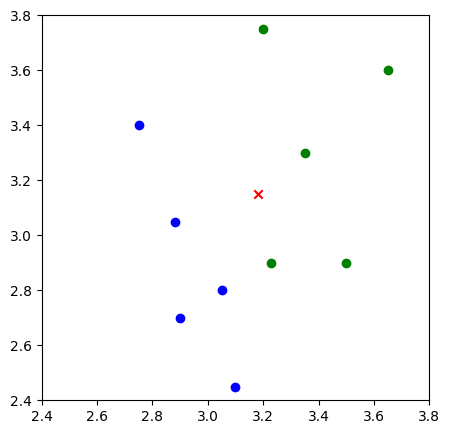

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))
plt.xlim((2.4, 3.8))
plt.ylim((2.4, 3.8))

# 返回每个数据的x特征值
x_feature = list(map(lambda x: x[0], features))

# 返回每个数据的特征值
y_feature = list(map(lambda y: y[1], features))

# 在画布上绘画出"A"类标签的数据点
plt.scatter(x_feature[:5], y_feature[:5], c="b")

# 在画布上绘画出"B"类标签的数据点
plt.scatter(x_feature[5:], y_feature[5:], c="g")

# 待测试点的坐标为 [3.1，3.2]
plt.scatter([3.18], [3.15], c="r", marker="x")

## 算法实现（Python版本）

### 曼哈顿距离
假设向量维度为n，计算公式为：
$$
d_{(x_i, x_j)} = \sum_{l=1}^n \lvert x_i^{l} - x_j^{l} \rvert
$$

In [4]:
def d_man(x, y):
    """计算曼哈顿距离"""
    d = np.sum(np.abs(x - y))
    return d

In [5]:
x = np.array([3.1, 3.2])  # 任意指定 2 点计算
print("x:", x)

y = np.array([2.5, 2.8])
print("y:", y)

print(d_man(x, y))

x: [3.1 3.2]
y: [2.5 2.8]
1.0000000000000004


### 欧式距离
$$
d_{(x_i, x_j)} = \sqrt{\sum_{l=1}^n ( x_i^{l} - x_j^{l} ) ^ 2}
$$

In [6]:
def d_euc(x, y):
    """计算欧式距离"""
    d = np.sqrt(np.sum(np.square(x - y)))
    return d

In [7]:
x = np.random.random(10)  # 随机生成 10 个数的数组作为 x 特征的值
print("x:", x)

y = np.random.random(10)
print("y:", y)

distance_euc = d_euc(x, y)
print(distance_euc)


x: [0.76276864 0.0818717  0.30943126 0.60565318 0.6186818  0.65311095
 0.9182831  0.65362406 0.20700431 0.3499319 ]
y: [0.06722888 0.01714341 0.18262127 0.02235973 0.6286086  0.66990191
 0.41872205 0.37034806 0.70636929 0.67390755]
1.2364424596727632


### 多数表决算法

In [8]:
def majority_voting(class_count):
    """多数表决算法"""
    sorted_class_count = sorted(
        class_count.items(), key=lambda x: x[1], reverse=True)
    return sorted_class_count

arr = {'A': 3, 'B': 2, "C": 6, "D": 5}
majority_voting(arr)

[('C', 6), ('D', 5), ('A', 3), ('B', 2)]

### KNN算法实现

In [9]:
def knn_classify(test_data, train_data, labels, k):
    """knn算法实现"""
    # 创建一个空的数组用于存放距离
    distances = np.array([])
    
    # 使用欧式距离计算数据相似度
    for each_data in train_data:
        d = d_euc(test_data, each_data)
        distances = np.append(distances, d)
    
    # 获取按距离从小到大排序后的索引
    sorted_distance_index = distances.argsort()
    sorted_distance = np.sort(distances)
    r = (sorted_distance[k] + sorted_distance[k-1]) / 2  # 计算
    
    # 多数表决
    class_count = {}
    for i in range(k):
        vote_label = labels[sorted_distance_index[i]]
        class_count[vote_label] = class_count.get(vote_label, 0) + 1
    final_label = majority_voting(class_count)
    
    return final_label, r

In [10]:
test_data = np.array([3.18, 3.15])
final_label, r = knn_classify(test_data, features, labels, 5)
final_label

[('B', 3), ('A', 2)]

### 结果展示

In [11]:
def circle(r, a, b):
    """画圆，这里采用极坐标的方式对圆进行表示 ：x=r*cosθ，y=r*sinθ"""
    theta = np.arange(0, 2*np.pi, 0.01)
    x = a+r * np.cos(theta)
    y = b+r * np.sin(theta)
    return x, y

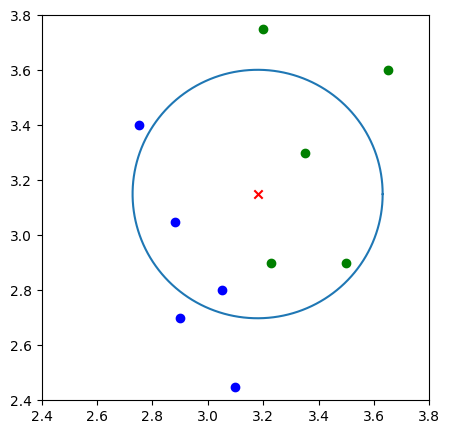

In [12]:
plt.figure(figsize=(5, 5))
plt.xlim((2.4, 3.8))
plt.ylim((2.4, 3.8))

# 返回每个数据的 x 特征值
x_feature = list(map(lambda x: x[0], features))
y_feature = list(map(lambda y: y[1], features))

# 在画布上绘画出"A"类标签的数据点
plt.scatter(x_feature[:5], y_feature[:5], c="b")

# 在画布上绘画出"B"类标签的数据点
plt.scatter(x_feature[5:], y_feature[5:], c="g")

# 待测试点的坐标为 [3.18，3.15]
plt.scatter([3.18], [3.15], c="r", marker="x")

k_circle_x, k_circle_y = circle(r, 3.18, 3.15)
plt.plot(k_circle_x, k_circle_y)

## 算法实现（scikit-learn版本）

### 数据prepare

In [13]:
import pandas as pd

lilac_data = pd.read_csv('../data/course-9-syringa.csv')
lilac_data.head()

,sepal_length,sepal_width,petal_length,petal_width,labels
0,5.1,3.5,2.4,2.1,daphne
1,4.9,3.0,2.7,1.7,daphne
2,4.7,3.2,2.2,1.4,daphne
3,4.6,3.1,1.6,1.7,daphne
4,5.0,3.6,1.6,1.4,daphne


In [14]:
unique_labels = lilac_data['labels'].unique()
unique_labels

array(['daphne', 'syringa', 'willow '], dtype=object)

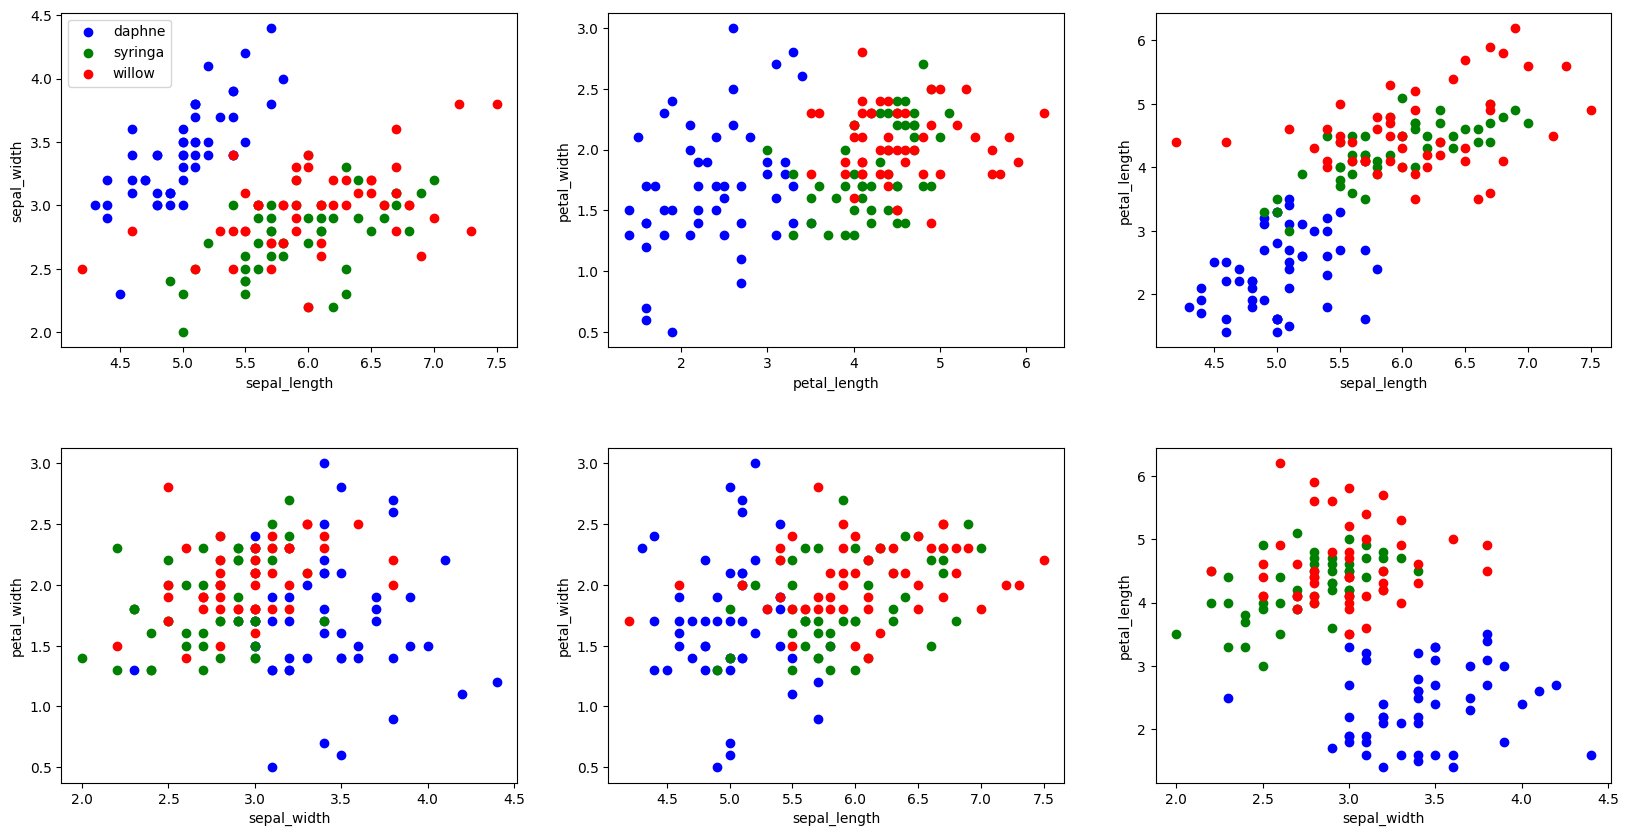

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

"""绘制丁香花特征子图
"""

# 构建生成 2*3 的画布，2 行 3 列
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# 定义每个画布内的行间隔和高间隔
fig.subplots_adjust(hspace=0.3, wspace=0.2)

axes[0, 0].set_xlabel("sepal_length")  # 定义 x 轴坐标值
axes[0, 0].set_ylabel("sepal_width")  # 定义 y 轴坐标值
axes[0, 0].scatter(lilac_data.sepal_length[:50],
                   lilac_data.sepal_width[:50], c="b")
axes[0, 0].scatter(lilac_data.sepal_length[50:100],
                   lilac_data.sepal_width[50:100], c="g")
axes[0, 0].scatter(lilac_data.sepal_length[100:],
                   lilac_data.sepal_width[100:], c="r")
axes[0, 0].legend(["daphne", "syringa", "willow"], loc=2)  # 定义示例

axes[0, 1].set_xlabel("petal_length")
axes[0, 1].set_ylabel("petal_width")
axes[0, 1].scatter(lilac_data.petal_length[:50],
                   lilac_data.petal_width[:50], c="b")
axes[0, 1].scatter(lilac_data.petal_length[50:100],
                   lilac_data.petal_width[50:100], c="g")
axes[0, 1].scatter(lilac_data.petal_length[100:],
                   lilac_data.petal_width[100:], c="r")

axes[0, 2].set_xlabel("sepal_length")
axes[0, 2].set_ylabel("petal_length")
axes[0, 2].scatter(lilac_data.sepal_length[:50],
                   lilac_data.petal_length[:50], c="b")
axes[0, 2].scatter(lilac_data.sepal_length[50:100],
                   lilac_data.petal_length[50:100], c="g")
axes[0, 2].scatter(lilac_data.sepal_length[100:],
                   lilac_data.petal_length[100:], c="r")

axes[1, 0].set_xlabel("sepal_width")
axes[1, 0].set_ylabel("petal_width")
axes[1, 0].scatter(lilac_data.sepal_width[:50],
                   lilac_data.petal_width[:50], c="b")
axes[1, 0].scatter(lilac_data.sepal_width[50:100],
                   lilac_data.petal_width[50:100], c="g")
axes[1, 0].scatter(lilac_data.sepal_width[100:],
                   lilac_data.petal_width[100:], c="r")

axes[1, 1].set_xlabel("sepal_length")
axes[1, 1].set_ylabel("petal_width")
axes[1, 1].scatter(lilac_data.sepal_length[:50],
                   lilac_data.petal_width[:50], c="b")
axes[1, 1].scatter(lilac_data.sepal_length[50:100],
                   lilac_data.petal_width[50:100], c="g")
axes[1, 1].scatter(lilac_data.sepal_length[100:],
                   lilac_data.petal_width[100:], c="r")

axes[1, 2].set_xlabel("sepal_width")
axes[1, 2].set_ylabel("petal_length")
axes[1, 2].scatter(lilac_data.sepal_width[:50],
                   lilac_data.petal_length[:50], c="b")
axes[1, 2].scatter(lilac_data.sepal_width[50:100],
                   lilac_data.petal_length[50:100], c="g")
axes[1, 2].scatter(lilac_data.sepal_width[100:],
                   lilac_data.petal_length[100:], c="r")

### 划分训练集和测试集

In [16]:
from sklearn.model_selection import train_test_split

feature_data = lilac_data.iloc[:, :-1]
label_data = lilac_data["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    feature_data, label_data, test_size=0.3, random_state=2)

X_test

,sepal_length,sepal_width,petal_length,petal_width
6,4.6,3.4,2.5,1.6
3,4.6,3.1,1.6,1.7
113,5.1,2.5,4.6,2.0
12,4.8,3.0,2.2,1.5
24,4.8,3.4,2.1,2.2
129,6.2,3.0,4.0,1.6
25,5.0,3.0,3.3,1.7
108,5.7,2.5,4.1,2.8
128,5.9,2.8,4.1,2.1
45,4.8,3.0,1.9,1.5


### 算法实现

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_classify(train_data, label_data, test_data, k_num):
    """k-近邻算法实现"""
    # 使用 sklearn 构建 KNN 预测模型
    knn = KNeighborsClassifier(n_neighbors=k_num)
    # 训练数据集
    knn.fit(train_data, label_data)
    # 预测
    predict_label = knn.predict(test_data)
    # 返回预测值
    return predict_label

In [18]:
# 使用测试数据进行预测
y_predict = sklearn_classify(X_train, y_train, X_test, 3)
y_predict

array(['daphne', 'daphne', 'willow ', 'daphne', 'daphne', 'willow ',
       'daphne', 'syringa', 'willow ', 'daphne', 'daphne', 'daphne',
       'daphne', 'daphne', 'syringa', 'syringa', 'syringa', 'willow ',
       'syringa', 'willow ', 'syringa', 'willow ', 'willow ', 'syringa',
       'syringa', 'daphne', 'daphne', 'willow ', 'daphne', 'willow ',
       'willow ', 'daphne', 'syringa', 'willow ', 'willow ', 'daphne',
       'willow ', 'willow ', 'syringa', 'willow ', 'willow ', 'willow ',
       'willow ', 'syringa', 'daphne'], dtype=object)

In [19]:
import numpy as np

def get_accuracy(test_labels, pred_labels):
    """计算准确率"""
    correct = np.sum(test_labels == pred_labels)  # 计算预测正确的数据个数
    n = len(test_labels)  # 总测试集数据个数
    accur = correct/n
    return accur

get_accuracy(y_test, y_predict)

0.7777777777777778

### 选择K值

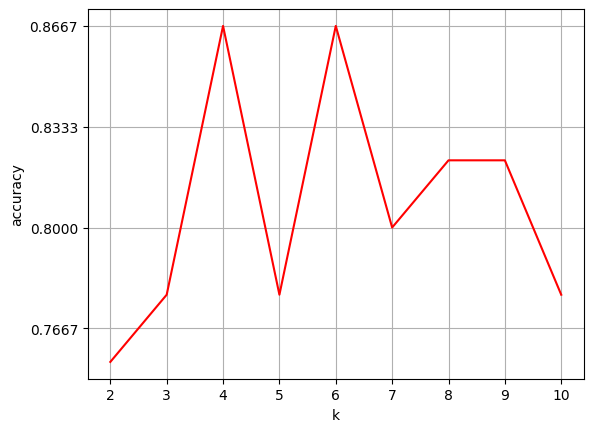

In [20]:
normal_accuracy = []
k_value = range(2, 11)
for k in k_value:
    y_predict = sklearn_classify(X_train, y_train, X_test, k)
    accuracy = get_accuracy(y_test, y_predict)
    normal_accuracy.append(accuracy)

# 设置横、纵坐标轴的名称
plt.xlabel("k")
plt.ylabel("accuracy")

# 设定 y 轴显示，从 0.6 到 0.9
new_ticks = np.linspace(0.6, 0.9, 10)
plt.yticks(new_ticks)

plt.plot(k_value, normal_accuracy, c='r')

# 给画布增加网格
plt.grid(True)